# Libraries

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
import pandas as pd
import numpy as np
#nltk.download('wordnet')
import itertools
import os
import re

from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition

import matplotlib.pyplot as plt
import pandas, numpy, textblob, string

from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout

# Insert the path of the files

In [2]:
### Insert the path with the clean scores
path = ""

# Get the names and the scores

In [3]:
#path = 'D:\\filings_clean_withscore'

files = []
# r=root, d=directories, f=files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))
scores = []
names = []
for f in files:
    scores.append(re.findall("_\d_\d_\d_\d", f))
    names.append(re.findall("text_10k_(.*)(?=_\d_\d_\d_)", f))

names_joined = [' '.join(x) for x in names]
text_dict  = {}

# Insert the text in a dictionary and create a dataframe

In [4]:
for file, name in zip(files, names_joined):
    with open(file, "r") as myfile:
        text_dict[name] = myfile.read().replace("\n", " ")

df_text = pd.DataFrame(text_dict.items(), columns=["id", "text"])
del text_dict, names
scores_joined = [' '.join(x) for x in scores]
del scores

# Create columns for the ESG scores

In [5]:

df_text["total_esg"] = 0
df_text["E_score"] = 0
df_text["S_score"] = 0
df_text["G_score"] = 0

for row in range(len(df_text)):
    df_text["total_esg"].iloc[row] = scores_joined[row].split("_")[1]
    df_text["E_score"].iloc[row] = scores_joined[row].split("_")[2]
    df_text["S_score"].iloc[row] = scores_joined[row].split("_")[3]
    df_text["G_score"].iloc[row] = scores_joined[row].split("_")[4]
  


C:\Users\Hella\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Text preprocessing

In [9]:
documents = []


stemmer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

for sen in range(0, len(df_text)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df_text["text"][sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Replace numbers with "number"
    document = re.sub(r'[0-9]+', 'number', document)
    
    # Remove punctuation
    document = re.sub(r'[^\w\s]', "", document)
    
    # Remove underscore
    document = re.sub(r'_+', 'underscore', document)
    
    # Converting to Lowercase
    document = document.lower()

    # Tokenizing
    document = document.split()

    
    # Lemmatizing
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)
    
for row_t in range(len(df_text)):
    df_text["text"].iloc[row_t] = documents[row_t]

del documents

C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Feature engineering

In [11]:
df_text['char_count'] = df_text['text'].apply(len)
df_text['word_count'] = df_text['text'].apply(lambda x: len(x.split()))
df_text['word_density'] = df_text['char_count'] / (df_text['word_count']+1)

C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [13]:
# Filepath locations
stopWordsFile = 'StopWords_Generic.txt'
positiveWordsFile = 'PositiveWords.txt'
nagitiveWordsFile = 'NegativeWords.txt'
uncertainty_dictionaryFile = 'uncertainty_dictionary.txt'
constraining_dictionaryFile = 'constraining_dictionary.txt'

In [14]:
with open(stopWordsFile ,'r') as stop_words:
    stopWords = stop_words.read().lower()
stopWordList = stopWords.split('\n')
stopWordList[-1:] = []


def tokenizer(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_words = list(filter(lambda token: token not in stopWordList, tokens))
    return filtered_words

# Loading positive words
with open(positiveWordsFile,'r') as posfile:
    positivewords=posfile.read().lower()
positiveWordList=positivewords.split('\n')

# Loading negative words
with open(nagitiveWordsFile ,'r') as negfile:
    negativeword=negfile.read().lower()
negativeWordList=negativeword.split('\n')

# Calculating positive score 
def positive_score(text):
    numPosWords = 0
    rawToken = tokenizer(text)
    for word in rawToken:
        if word in positiveWordList:
            numPosWords  += 1
    
    sumPos = numPosWords
    return sumPos

# Calculating Negative score
def negative_word(text):
    numNegWords=0
    rawToken = tokenizer(text)
    for word in rawToken:
        if word in negativeWordList:
            numNegWords -=1
    sumNeg = numNegWords 
    sumNeg = sumNeg * -1
    return sumNeg

# Calculating polarity score
def polarity_score(positiveScore, negativeScore):
    pol_score = (positiveScore - negativeScore) / ((positiveScore + negativeScore) + 0.000001)
    return pol_score

# Calculating Average sentence length 
# It will calculated using formula --- Average Sentence Length = the number of words / the number of sentences
     
def average_sentence_length(text):
    sentence_list = sent_tokenize(text)
    tokens = tokenizer(text)
    totalWordCount = len(tokens)
    totalSentences = len(sentence_list)
    average_sent = 0
    if totalSentences != 0:
        average_sent = totalWordCount / totalSentences
    
    average_sent_length= average_sent
    
    return round(average_sent_length)

# Calculating percentage of complex word 
# It is calculated using Percentage of Complex words = the number of complex words / the number of words 

def percentage_complex_word(text):
    tokens = tokenizer(text)
    complexWord = 0
    complex_word_percentage = 0
    
    for word in tokens:
        vowels=0
        if word.endswith(('es','ed')):
            pass
        else:
            for w in word:
                if(w=='a' or w=='e' or w=='i' or w=='o' or w=='u'):
                    vowels += 1
            if(vowels > 2):
                complexWord += 1
    if len(tokens) != 0:
        complex_word_percentage = complexWord/len(tokens)
    
    return complex_word_percentage

# calculating Fog Index 
# Fog index is calculated using -- Fog Index = 0.4 * (Average Sentence Length + Percentage of Complex words)

def fog_index(averageSentenceLength, percentageComplexWord):
    fogIndex = 0.4 * (averageSentenceLength + percentageComplexWord)
    return fogIndex

# Counting complex words
def complex_word_count(text):
    tokens = tokenizer(text)
    complexWord = 0
    
    for word in tokens:
        vowels=0
        if word.endswith(('es','ed')):
            pass
        else:
            for w in word:
                if(w=='a' or w=='e' or w=='i' or w=='o' or w=='u'):
                    vowels += 1
            if(vowels > 2):
                complexWord += 1
    return complexWord

#Counting total words

def total_word_count(text):
    tokens = tokenizer(text)
    return len(tokens)

# calculating uncertainty_score
with open(uncertainty_dictionaryFile ,'r') as uncertain_dict:
    uncertainDict=uncertain_dict.read().lower()
uncertainDictionary = uncertainDict.split('\n')

def uncertainty_score(text):
    uncertainWordnum =0
    rawToken = tokenizer(text)
    for word in rawToken:
        if word in uncertainDictionary:
            uncertainWordnum +=1
    sumUncertainityScore = uncertainWordnum 
    
    return sumUncertainityScore

# calculating constraining score
with open(constraining_dictionaryFile ,'r') as constraining_dict:
    constrainDict=constraining_dict.read().lower()
constrainDictionary = constrainDict.split('\n')

def constraining_score(text):
    constrainWordnum =0
    rawToken = tokenizer(text)
    for word in rawToken:
        if word in constrainDictionary:
            constrainWordnum +=1
    sumConstrainScore = constrainWordnum 
    
    return sumConstrainScore

# Calculating positive word proportion

def positive_word_prop(positiveScore,wordcount):
    positive_word_proportion = 0
    if wordcount !=0:
        positive_word_proportion = positiveScore / wordcount
        
    return positive_word_proportion

# Calculating negative word proportion

def negative_word_prop(negativeScore,wordcount):
    negative_word_proportion = 0
    if wordcount !=0:
        negative_word_proportion = negativeScore / wordcount
        
    return negative_word_proportion

# Calculating uncertain word proportion

def uncertain_word_prop(uncertainScore,wordcount):
    uncertain_word_proportion = 0
    if wordcount !=0:
        uncertain_word_proportion = uncertainScore / wordcount
        
    return uncertain_word_proportion

# Calculating constraining word proportion

def constraining_word_prop(constrainingScore,wordcount):
    constraining_word_proportion = 0
    if wordcount !=0:
        constraining_word_proportion = constrainingScore / wordcount
        
    return constraining_word_proportion

# calculating Constraining words for whole report

def constrain_word_whole(mdaText,qqdmrText,rfText):
    wholeDoc = mdaText + qqdmrText + rfText
    constrainWordnumWhole =0
    rawToken = tokenizer(wholeDoc)
    for word in rawToken:
        if word in constrainDictionary:
            constrainWordnumWhole +=1
    sumConstrainScoreWhole = constrainWordnumWhole 
    
    return sumConstrainScoreWhole

In [15]:
df_text["positive_score"] = df_text["text"].apply(positive_score)
df_text["negative_score"] = df_text["text"].apply(negative_word)
df_text["polarity_score"] = np.vectorize(polarity_score)(df_text["positive_score"], df_text["negative_score"])
df_text["average_sen_len"] = df_text["text"].apply(average_sentence_length)
df_text["percentage_complex_word"] = df_text["text"].apply(percentage_complex_word)
df_text["fog_index"] = np.vectorize(fog_index)(df_text["average_sen_len"], df_text["percentage_complex_word"])
df_text["complex_word_count"] = df_text["text"].apply(complex_word_count)
df_text["uncertainty_score"] = df_text["text"].apply(uncertainty_score)
df_text["constraining_score"] = df_text["text"].apply(constraining_score)
df_text["positive_word_prop"] = np.vectorize(positive_word_prop)(df_text["positive_score"], df_text["word_count"])
df_text["negative_word_prop"] = np.vectorize(negative_word_prop)(df_text["negative_score"],df_text["word_count"])
df_text["uncertain_word_prop"] = np.vectorize(uncertain_word_prop)(df_text["uncertainty_score"],df_text["word_count"])
df_text["constraining_word_prop"] = np.vectorize(constraining_word_prop)(df_text["constraining_score"],df_text["word_count"])

C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Hella\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

## Group of words creation

In [17]:


groups_dict = {
     "group_positive_all": ["strike", "greenhouse", "energy", "fuel","gas","emission","fraudulent","climate","water","food","welfare","cautionary","africa"],#positive for total
     "group_positive_e": ["weather" , "sustainable", "fleet","light","engine","flood","chemical"], #positive for E
     "group_positive_s": ["oil", "consumption", "retiree", "family","poor","safe","carbon","medical"], #positive for S
     "group_positive_g": ["cancelable", "insolvency", "differentiate","metric","strategically","synergy"], #positive for G
     "group_neative_all": ["noncompliance", "steel", "recoverability","contaminated","collusion","removal"], #negative for total
     "group_negative_e": ["unused", "prevented", "mechanical"], #negative for E
     "group_negative_s": ["severity", "transmission", "salary","threatened"], #negative for S
     "group_negative_g": ["minor", "waste","electricity"] #negative for G
     }


groups_dat = pd.DataFrame(index=range(0,len(df_text)), columns = ["group_positive_all", "group_positive_e", "group_positive_s",
                                               "group_positive_g", "group_neative_all", "group_negative_e",
                                               "group_negative_s", "group_negative_g"])


In [18]:
for w in groups_dict.keys():
    for i in range(len(df_text)):
        L3 = [j for j in df_text["text"][i].split() if j in groups_dict[w]]
        groups_dat[w].iloc[i] = len(L3)
        


In [19]:
df_text = df_text.join(groups_dat)

# Bag of words

In [17]:
# # create a count vectorizer object 
# count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words="english", max_df = 0.8, min_df = 0.2)
# count_vect.fit(df_text['text'])

# # transform the training and validation data using count vectorizer object
# xtrain_count =  count_vect.transform(df_text["text"])


# Term Frequency - Inverse Document Frequency (TF-IDF)

In [21]:
#word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50, stop_words='english', max_df = 0.6, min_df=0.4)
tfidf_vect.fit(df_text['text'])
xtrain_tfidf =  tfidf_vect.transform(df_text["text"])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50, ngram_range=(2,2), stop_words='english', max_df = 0.6, min_df=0.4)
tfidf_vect_ngram.fit(df_text['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(df_text["text"])


In [22]:
df_tfidf = pd.DataFrame(xtrain_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

In [23]:
df_ngrams = pd.DataFrame(xtrain_tfidf_ngram.toarray(), columns=tfidf_vect_ngram.get_feature_names())

# Latent Dirichlet Allocation (LDA) (Did not use)

In [18]:
# # train a LDA Model
# lda_model = decomposition.LatentDirichletAllocation(n_components=10, 
#                                                     learning_method='online', 
#                                                     max_iter=50,
#                                                     random_state=123,
#                                                     n_topics = 10,
#                                                     evaluate_every = -1)
# X_topics = lda_model.fit_transform(xtrain_count)
# topic_word = lda_model.components_ 
# vocab = count_vect.get_feature_names()

# # Log Likelyhood: Higher the better
# print("Log Likelihood: ", lda_model.score(xtrain_count))

# # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# print("Perplexity: ", lda_model.perplexity(xtrain_count))

# # See model parameters
# print(lda_model.get_params())

#view the topic models
# n_top_words = 10
# topic_summaries = []
# for i, topic_dist in enumerate(topic_word):
#     topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
#     topic_summaries.append(' '.join(topic_words))

# #n_topics = [10, 15, 20, 25, 30]
# # Create Document - Topic Matrix
# lda_output = lda_model.transform(xtrain_count)

# # column names
# topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]

# # index names
# docnames = ["Doc" + str(i) for i in range(len(df_text))]

# # Make the pandas dataframe
# df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=range(len(df_text)))

# # Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

C:\Users\Hella\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [155]:
words_grams = df_tfidf.join(df_ngrams)

In [156]:
df_rel = df_text.join(words_grams) ## keep

In [158]:
df_rel.drop(columns=["text", "id"], inplace=True)

# Standardizing

In [159]:
x = df_rel[['char_count',
       'word_count', 'word_density', 'positive_score', 'negative_score',
       'polarity_score', 'average_sen_len', 'percentage_complex_word',
       'fog_index', 'complex_word_count', 'uncertainty_score',
       'constraining_score', 'positive_word_prop', 'negative_word_prop',
       'uncertain_word_prop', 'constraining_word_prop', 'group_positive_all',
       'group_positive_e', 'group_positive_s', 'group_positive_g',
       'group_neative_all', 'group_negative_e', 'group_negative_s',
       'group_negative_g']] #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df_rel[['char_count',
       'word_count', 'word_density', 'positive_score', 'negative_score',
       'polarity_score', 'average_sen_len', 'percentage_complex_word',
       'fog_index', 'complex_word_count', 'uncertainty_score',
       'constraining_score', 'positive_word_prop', 'negative_word_prop',
       'uncertain_word_prop', 'constraining_word_prop', 'group_positive_all',
       'group_positive_e', 'group_positive_s', 'group_positive_g',
       'group_neative_all', 'group_negative_e', 'group_negative_s',
       'group_negative_g']] = pd.DataFrame(x_scaled, dtype="float32")

C:\Users\Hella\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Hella\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Train-test split

In [160]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_rel.drop(columns=['total_esg','E_score','S_score','G_score']), 
                                                                    df_rel[['total_esg','E_score','S_score','G_score']], 
                                                                    test_size = 0.2, 
                                                                    random_state = 123)
### Split into validation and test set
x1_train, x1_test, y1_train, y1_test = model_selection.train_test_split(x_test, y_test, test_size = 0.5, random_state = 123)




y_train1 = y_train["total_esg"]
y_train2 = y_train["E_score"]
y_train3 = y_train["S_score"]
y_train4 = y_train["G_score"]

y_test1 = y_test["total_esg"]
y_test2 = y_test["E_score"]
y_test3 = y_test["S_score"]
y_test4 = y_test["G_score"]



y1_train1 = y1_train["total_esg"]
y1_train2 = y1_train["E_score"]
y1_train3 = y1_train["S_score"]
y1_train4 = y1_train["G_score"]

y1_test1 = y1_test["total_esg"]
y1_test2 = y1_test["E_score"]
y1_test3 = y1_test["S_score"]
y1_test4 = y1_test["G_score"]


# Deep Neural Network

# Model Tuning

In [38]:
# first_layer = [120, 100, 80]
# second_layer = [70, 60]
# third_layer = [50]
# fourth_layer = [30]

# # # create model
# for first in first_layer:
#     for second in second_layer:
#         for third in third_layer:
#             for fourth in fourth_layer:

#                 inputs = Input(shape = (124,))
#                 layer1 = Dense(first, activation = 'relu')(inputs)
#                 layer1 = Dropout(0.2)(layer1)

#                 layer2 = Dense(second, activation = 'relu')(layer1)
#                 layer2 = Dropout(0.2)(layer2)


#                 layer3 = Dense(third, activation = 'relu')(layer2)
#                 layer3 = Dropout(0.2)(layer3)

#                 layer4 = Dense(fourth, activation = 'relu')(layer3)
#                 layer4 = Dropout(0.2)(layer4)





#                 out1 = Dense(3, activation='softmax')(layer4)
#                 out2 = Dense(3, activation='softmax')(layer4)
#                 out3 = Dense(3, activation='softmax')(layer4)
#                 out4 = Dense(3, activation='softmax')(layer4)
#                 model = Model(inputs = inputs, outputs = [out1, out2, out3, out4])

#                 # Compile the model
#                 adamg = optimizers.adam(lr=0.001, decay=0.001)
#                 model.compile(optimizer = 'adam',
#                               loss = "sparse_categorical_crossentropy", # Call the loss function with the selected layer
#                               metrics = ['accuracy'])

#                 callbacks = [EarlyStopping(monitor='val_loss', patience=30),
#                             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#                 history = model.fit([x_train], [y_train1, y_train2, y_train3, y_train4],
#                          validation_data=([x_test], [y_test1, y_test2, y_test3, y_test4]),
#                          epochs = 800, verbose=False, callbacks=callbacks)

#                 total_loss, val_loss1, val_loss2, val_loss3,val_loss4, val_acc1, val_acc2, val_acc3, val_acc4 = model.evaluate([x_test], [y_test1, y_test2, y_test3, y_test4])
#                 print(f'accuracy:{sum([val_acc1, val_acc2, val_acc3, val_acc4])/len([val_acc1, val_acc2, val_acc3, val_acc4])*100}, first :{first}, second: {second}, third:{third}, fourth:{fourth}')



# Final Model

In [161]:
#### Core layers
inputs = Input(shape = (124,))
layer1 = Dense(130, activation = 'relu')(inputs)
layer1 = Dropout(0.2)(layer1)

layer2 = Dense(80, activation = 'relu')(layer1)
layer2 = Dropout(0.2)(layer2)


layer3 = Dense(40, activation = 'relu', kernel_initializer='normal')(layer2)
layer3 = Dropout(0.2)(layer3)






out1 = Dense(3, activation='softmax', kernel_initializer='normal')(layer3)
out2 = Dense(3, activation='softmax')(layer3)
out3 = Dense(3, activation='softmax')(layer3)
out4 = Dense(3, activation='softmax')(layer3)
model = Model(inputs = inputs, outputs = [out1, out2, out3, out4])

# Compile the model
model.compile(optimizer = 'adam',
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=30),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history = model.fit([x_train], [y_train1, y_train2, y_train3, y_train4],
         validation_data=([x1_train], [y1_train1, y1_train2, y1_train3, y1_train4]),
         epochs = 800, verbose=False, callbacks=callbacks)

# Graph of loss

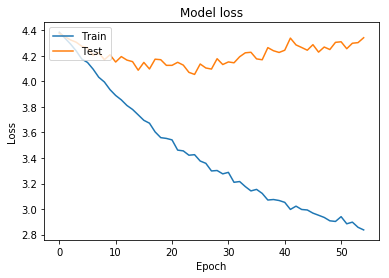

In [148]:
# Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Accuracy on the test set

In [149]:
total_loss, val_loss1, val_loss2, val_loss3,val_loss4, val_acc1, val_acc2, val_acc3, val_acc4 = model.evaluate([x1_test], [y1_test1, y1_test2, y1_test3, y1_test4])
print(sum([val_acc1, val_acc2, val_acc3, val_acc4])/len([val_acc1, val_acc2, val_acc3, val_acc4])*100)

377/377 [==============================] - 0s 135us/step
51.12732087783218


# Accuracy of the separate scores

In [150]:
model.evaluate([x1_test], [y1_test1, y1_test2, y1_test3, y1_test4])

377/377 [==============================] - 0s 116us/step


[4.313089222743593,
 1.087343040448601,
 1.0923970466583415,
 1.0585465358486226,
 1.074802675677231,
 0.5172413791522423,
 0.4854111398720931,
 0.5145888581516256,
 0.5278514579373266]

# Get the objective function

In [151]:
a = model.predict(x1_test)

obj = pd.DataFrame(index = range(len(y1_test)))

obj["total_esg"] = 0
obj["E_score"] = 0
obj["S_score"] = 0
obj["G_score"] = 0

for score in range(len(y1_test)):
    obj["total_esg"].iloc[score] = np.argmax(a[0][score])
    obj["E_score"].iloc[score] = np.argmax(a[1][score])
    obj["S_score"].iloc[score] = np.argmax(a[2][score])
    obj["G_score"].iloc[score] = np.argmax(a[3][score])

In [152]:
obj["theta"] = 0
def objective(y_true0, y_pred0, y_true1, y_pred1, y_true2, y_pred2, y_true3, y_pred3):
   counter = (y_pred1 == y_true1)*1 + (y_pred2 == y_true2)*1 + (y_pred3 == y_true3)*1
   if (counter == 0):
       counter == 1
   return (y_pred0 == y_true0)*counter

In [153]:
obj["theta"] = np.vectorize(objective)(y1_test["total_esg"],
                                       obj["total_esg"],
                                       y1_test["E_score"],
                                       obj["E_score"],
                                       y1_test["S_score"],
                                       obj["S_score"],
                                       y1_test["G_score"],
                                       obj["G_score"])

In [154]:
print(f"The objective function is {obj.sum()[4]}")

The objective function is 393
